In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
// Code to be able to number equations in the markdown

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## Explicit finite difference scheme

### Rewriting equation in terms of row (position) and column (time) indicies.

The equation (Eq. 4.0 in doc) given to me by Jack is: 

$$ E^{n+1}_i = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right )^2 (E^{n}_{i+1} - 2E^{n}_{i} + E^{n}_{i-1})-(-2E^{n}_{i} + E^{n-1}_{i}) $$

I want to have the equation in terms of rows and columns, so ultimately I want to rewrite the following equation to be in the form of rows and columns: 

\begin{equation}
E^{n+1}_{i} = rE^{n}_{i-1} + (1-2r)E^{n}_{i} + rE^{n}_{i+1} - (-2E^{n}_{i} + E^{n-1}_{i})
\end{equation}

where $ \displaystyle r = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right )^2 $ and n is the position index and i is the time index (dimensionless)

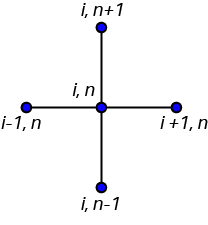

Using the image above, we use [i,n] ; [i-1,n] ; [i+1,n] ; [i, n-1] and take a weighted average to find [i,n+1].

### Defining global arrays for I, E, T_e, T_i, n_e, rho


In [5]:
I = np.zeros((10, 10))
E = np.zeros((10, 10))
T_e = np.zeros((10, 10))
T_i = np.zeros((10, 10))
n_e = np.zeros((10, 10))
rho = np.zeros((10, 10))

### Defining parameters needed to solve differential equation: $ \nabla^{2} E - \frac{n^2}{c^2} \frac{\partial^2 E}{\partial t^{2}} = 0$

In [6]:
# Unit conversions
ps = 10**-12    # picoseconds unit
nm = 10**-9     # nanometers unit
um = 10 ** -6   # micrometer unit
    
# Physical parameters
RefractiveIndex = 1                         # unitless
speed_of_light = 299792458                  # in m/s
wavelength = 351 * nm

# Physics formulas
frequency = speed_of_light/wavelength       # in Hertz
angular_frequency = 2 * np.pi * frequency   # in Hertz
wavenumber = (2 * np.pi) / wavelength       # wave number 'k' will be imaginary part in the coming days (when we do it correctly)

# Grid and time parameters
T = 1 * ps              # time in seconds (* picoseonds) (in the future, will represent modeling time)
n_timestep = 100       # n time step
L = 500 * nm            # length in SI units in meters
n_cells = 10            # number of cells (can also think of as number of grid points)
delta_x = L/n_cells     # spatial time-step (can also think of as grid spacing)
delta_t = T/n_timestep  # time related time-step

### Initializing laser intensity and electric field

In [7]:
R = 25 * um # radius of laser
E_L = 10 * (10 ** -6) # in joules laser energy (10 mu joules)
Area_L = np.pi * R **2 # area of laser
T_laser = 100 * ps # laser pulse time
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )
permittivity_free_space = 8.85418782 * 10 **-12

# Electric field
E_0 = np.sqrt( (2 * I_0) / (speed_of_light * RefractiveIndex * permittivity_free_space) ) # SI unit is voltage / m

# Laser intensity
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )

### Solving Eq (1) explicitly: $E^{n+1}_{i} = rE^{n}_{i-1} + (1-2r)E^{n}_{i} + rE^{n}_{i+1} - (-2E^{n}_{i} + E^{n-1}_{i})$

In [8]:
x = []  # spatial domain (can also think of as coordinates of grid points)
t = []  # time domain

# Creating arrays for the spatial and time domains. Starting at -2 in order to create ghost cells. And ending with + 3 for the same reason
# The ghost cells are there so that in the matrix we can access all indeces
# To append, using formula Dr. Woo gave me: X_i = delta_x(i + 1/2)
for i in range(-2, n_cells + 3):
    x.append(delta_x * (i + 0.5))

for i in range(-2, n_timestep + 3):
    t.append(delta_t * (i + 0.5))
    
x = np.array(x)
t = np.array(t)
E = np.zeros((len(t), len(x)))

r_const = ((delta_t/delta_x) * (speed_of_light/RefractiveIndex)) ** 2 # our parameter

# These loops will go through the grid. We start at 1 so as to not calculate the
# value when the a time or spatial point is equal to 0.
index = 0
for n in range(2, len(t) - 3):
    t_sim = t[n] # in seconds
    
    # Assignment of boundary conditions in space:
    
    # Instantenously defining the boundary conditions/values of ghost cells on the RIGHT:
    E[n, 0] = E_0 * np.sin( angular_frequency * t_sim * -wavenumber * x[0] )
    E[n, 1] = E_0 * np.sin( angular_frequency * t_sim * -wavenumber * x[1] )
    
    # We have no laser on the left, so boundary conditions are just 0
    E[n, -1] = 0
    E[n, -2] = 0
    
    # Initial conditions in time:
    E[1, 2:] = 0
    for i in range(2, len(x) - 3):
        print('index', index, 'n', n, 'i', i)
        E[n+1, i] = (r_const) * (E[n, i-1] + (1 - 2*r_const) * E[n, i] + r_const * E[n, i+1]) - (-2 * E[n, i] + E[n-1,i])
        index += 1


index 0 n 2 i 2
index 1 n 2 i 3
index 2 n 2 i 4
index 3 n 2 i 5
index 4 n 2 i 6
index 5 n 2 i 7
index 6 n 2 i 8
index 7 n 2 i 9
index 8 n 2 i 10
index 9 n 2 i 11
index 10 n 3 i 2
index 11 n 3 i 3
index 12 n 3 i 4
index 13 n 3 i 5
index 14 n 3 i 6
index 15 n 3 i 7
index 16 n 3 i 8
index 17 n 3 i 9
index 18 n 3 i 10
index 19 n 3 i 11
index 20 n 4 i 2
index 21 n 4 i 3
index 22 n 4 i 4
index 23 n 4 i 5
index 24 n 4 i 6
index 25 n 4 i 7
index 26 n 4 i 8
index 27 n 4 i 9
index 28 n 4 i 10
index 29 n 4 i 11
index 30 n 5 i 2
index 31 n 5 i 3
index 32 n 5 i 4
index 33 n 5 i 5
index 34 n 5 i 6
index 35 n 5 i 7
index 36 n 5 i 8
index 37 n 5 i 9
index 38 n 5 i 10
index 39 n 5 i 11
index 40 n 6 i 2
index 41 n 6 i 3
index 42 n 6 i 4
index 43 n 6 i 5
index 44 n 6 i 6
index 45 n 6 i 7
index 46 n 6 i 8
index 47 n 6 i 9
index 48 n 6 i 10
index 49 n 6 i 11
index 50 n 7 i 2
index 51 n 7 i 3
index 52 n 7 i 4
index 53 n 7 i 5
index 54 n 7 i 6
index 55 n 7 i 7
index 56 n 7 i 8
index 57 n 7 i 9
index 58 n 7 i

C:\Users\nickd\AppData\Local\Temp\ipykernel_18396\2860737529.py:39: RuntimeWarning: overflow encountered in scalar multiply
  E[n+1, i] = (r_const) * (E[n, i-1] + (1 - 2*r_const) * E[n, i] + r_const * E[n, i+1]) - (-2 * E[n, i] + E[n-1,i])
C:\Users\nickd\AppData\Local\Temp\ipykernel_18396\2860737529.py:39: RuntimeWarning: invalid value encountered in scalar subtract
  E[n+1, i] = (r_const) * (E[n, i-1] + (1 - 2*r_const) * E[n, i] + r_const * E[n, i+1]) - (-2 * E[n, i] + E[n-1,i])
C:\Users\nickd\AppData\Local\Temp\ipykernel_18396\2860737529.py:39: RuntimeWarning: overflow encountered in scalar add
  E[n+1, i] = (r_const) * (E[n, i-1] + (1 - 2*r_const) * E[n, i] + r_const * E[n, i+1]) - (-2 * E[n, i] + E[n-1,i])


In [9]:
E.shape

(105, 15)

In [10]:
# Remove all nan values from array
E = E[:, ~np.isnan(E).any(axis=0)]

## Laser source

Plot an animated wave through time.

In [11]:
%matplotlib notebook

In [ ]:
Y_UPPER_LIMIT = 3 * 10**8
Y_LOWER_LIMIT = -3 * 10**8

In [ ]:
fig, ax = plt.subplots()
line, = ax.plot([])     # A tuple unpacking to unpack the only plot
ax.set_xlim(0, 100)

ax.set_ylim(Y_LOWER_LIMIT, Y_UPPER_LIMIT)

def animate(frame_num):
    x_lis = E[frame_num,:]
    y = E[:,frame_num]
    line.set_data((x_lis, y))
    return line

anim = animation.FuncAnimation(fig, animate, frames=100, interval=20)
plt.show()

In [ ]:
fig, ax = plt.subplots()

lines = ax.plot(E)

def func(t, line):
#     t = np.arange(0,t,0.1)
    y = E
    line.set_data(t, y)
    return line
 
fig = plt.figure()
ax = plt.axes(xlim=(0, 100), ylim=(-1.2, 1.22))
redDots = plt.plot([], [], 'ro')
line = plt.plot([], [], lw=2)
 
# Creating the Animation object
line_ani = animation.FuncAnimation(fig, func, frames=np.arange(1,100,0.1), fargs=(line), interval=100, blit=False)
#line_ani.save(r'Animation.mp4')
 
plt.show()

In [13]:
arr=[]
for i in range(100):
    c=np.random.rand(10,10)        
    arr.append(c)
plt.imshow(arr[45])

In [15]:
fig = plt.figure()
i=0
im = plt.imshow(arr[0], animated=True)
def updatefig(*args):
    global i
    if (i<99):
        i += 1
    else:
        i=0
    im.set_array(arr[i])
    return im,
ani = animation.FuncAnimation(fig, updatefig,  blit=True)
plt.show()

In [ ]:



# ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
# plt.show()

In [ ]:
# plt.plot(E)
# plt.legend(t)
# plt.title('Solution with %d timesteps' %n_timestep)
# plt.xlabel("Time steps")
# #plt.ylabel("")
# plt.show()



In [ ]:
# fig, ax = plt.subplots()
# #t = np.linspace(0, 3, 40)
# #g = -9.81
# #v0 = 12
# # z = g * t**2 / 2 + v0 * t

# # v02 = 5
# # z2 = g * t**2 / 2 + v02 * t

# # scat = ax.scatter(t[0], z[0], c="b", s=5, label=f'v0 = {v0} m/s')
# line2 = ax.plot(E[0])[0]
# # ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
# # ax.legend()


# def update(frame):
#     # for each frame, update the data stored on each artist.
#     x_ls = t[:frame]
#     y_ls = E[:frame]
#     # update the scatter plot:
#     # update the line plot:
#     line2.set_xdata(t[:frame])
#     line2.set_ydata(z2[:frame])
#     return (scat, line2)


# ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
# plt.show()

In [ ]:
# def func(t, line):
#     y = np.sin(t)
#     line.set_data(t, y)
#     return line
 
# fig = plt.figure()
# ax = plt.axes(xlim=(0, 100), ylim=(-1.2, 1.22))
# redDots = plt.plot([], [], 'ro')
# line = plt.plot([], [], lw=2)
 
# # Creating the Animation object
# line_ani = animation.FuncAnimation(fig, func, frames=np.arange(1,100,0.1), fargs=(line), interval=100, blit=False)
# #line_ani.save(r'Animation.mp4')
 
 
# plt.show()